# Actividad Integradora

Presenta: David René Lagarica Hernández | A01708936
<!-- new line -->
17 de noviembre de 2023

## Problema

Felicidades! Eres el orgulloso propietario de 5 robots nuevos y un almacén lleno de cajas. El dueño anterior del almacén lo dejó en completo desorden, por lo que depende de tus robots organizar las cajas en algo parecido al orden y convertirlo en un negocio exitoso.

Cada robot está equipado con ruedas omnidireccionales y, por lo tanto, puede conducir en las cuatro direcciones. Pueden recoger cajas en celdas de cuadrícula adyacentes con sus manipuladores, luego llevarlas a otra ubicación e incluso construir pilas de hasta cinco cajas. Todos los robots están equipados con la tecnología de sensores más nueva que les permite recibir datos de sensores de las cuatro celdas adyacentes. Por tanto, es fácil distinguir si un campo está libre, es una pared, contiene una pila de cajas (y cuantas cajas hay en la pila) o está ocupado por otro robot. Los robots también tienen sensores de presión equipados que les indican si llevan una caja en ese momento.

Lamentablemente, tu presupuesto resultó insuficiente para adquirir un software de gestión de agentes múltiples de última generación. Pero eso no debería ser un gran problema ... ¿verdad? Tu tarea es enseñar a sus robots cómo ordenar su almacén. La organización de los agentes depende de ti, siempre que todas las cajas terminen en pilas ordenadas de cinco.

Puntos a considerar
•	La semilla para generación de números aleatorios será 67890.
•	El almacén es 20x20 celdas.
•	Al inicio de la simulación, tu solución deberá colocar 200 cajas repartidas en grupos de 1 a 3 cajas en posiciones aleatorias.
•	Todos los robots empiezan en posiciones aleatorias vacías. Y, sólo puede haber un robot por celda.
•	La simulación termina cuando todas las cajas se encuentra apiladas en pilas de exactamente 5 cajas.

## Solución

In [257]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import random
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [258]:
class Box(Agent):
    """Representa una caja en el almacén."""
    def __init__(self, id, model, pos):
        super().__init__(id, model)
        self.pos = pos

In [259]:
class Stack(Agent):
    """Representa una pila de cajas."""
    def __init__(self, id, model, pos):
        super().__init__(id, model)
        self.pos = pos
        self.boxes = []

    def add_box(self, box):
        self.boxes.append(box)

    def is_full(self):
        return len(self.boxes) == self.model.num_boxes_per_stack

In [260]:
class RobotAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.holding_box = False

    def find_nearest_incomplete_stack(self):
        # Encuentra la pila incompleta más cercana
        incomplete_stacks = [
            stack for stack in self.model.stacks if not stack.is_full()
        ]
        if not incomplete_stacks:
            return None

        # Calcular la distancia a cada pila incompleta y encontrar la más cercana
        closest_stack = min(
            incomplete_stacks, key=lambda stack: self.distance_to(stack.pos)
        )
        return closest_stack

    def distance_to_target(self, pos, target_pos):
        # Calcular la distancia Manhattan a un objetivo
        dx, dy = pos[0] - target_pos[0], pos[1] - target_pos[1]
        return abs(dx) + abs(dy)

    def move_towards(self, target_pos):
        # Moverse hacia una posición específica
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False
        )
        best_step = min(
            possible_steps, key=lambda pos: self.distance_to_target(pos, target_pos)
        )
        self.model.grid.move_agent(self, best_step)

    def move(self):
        if self.holding_box:
            # Moverse hacia la pila incompleta más cercana
            nearest_stack = self.find_nearest_incomplete_stack()
            if nearest_stack:
                self.move_towards(nearest_stack.pos)
        else:
            # Movimiento aleatorio si no lleva caja
            possible_steps = self.model.grid.get_neighborhood(
                self.pos, moore=False, include_center=False
            )
            new_position = self.random.choice(possible_steps)
            self.model.grid.move_agent(self, new_position)

    def distance_to(self, pos):
        # Calcular la distancia Manhattan desde la posición actual
        dx, dy = self.pos[0] - pos[0], self.pos[1] - pos[1]
        return abs(dx) + abs(dy)

    def pick_up_box(self):
        if not self.holding_box:
            neighbors = self.model.grid.get_neighborhood(
                self.pos, moore=False, include_center=False
            )
            for neighbor_pos in neighbors:
                box = next(
                    (box for box in self.model.boxes if box.pos == neighbor_pos), None
                )
                if box:
                    self.holding_box = box
                    self.model.boxes.remove(box)
                    self.model.grid.remove_agent(box)
                    break

    def stack_box(self):
        if self.holding_box:
            # Intentar encontrar una pila existente para añadir la caja
            nearest_stack = self.find_nearest_incomplete_stack()
            if (
                nearest_stack
                and self.distance_to(nearest_stack.pos) <= 1
                and not nearest_stack.is_full()
            ):
                nearest_stack.add_box(self.holding_box)
                self.holding_box = None

            elif not nearest_stack:
                # Si no hay pilas cercanas, crea una nueva
                id = "stack-" + str(self.model.next_stack_id)
                new_stack = Stack(id, self.model, self.pos)
                new_stack.add_box(self.holding_box)
                self.model.stacks.append(new_stack)
                self.model.grid.place_agent(new_stack, self.pos)
                self.holding_box = None

    def move_to_final_position(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False
        )
        for step in possible_steps:
            if not self.model.grid.is_cell_empty(step):
                continue
            if any(
                agent.pos == step
                for agent in self.model.schedule.agents
                if type(agent) == RobotAgent and agent != self
            ):
                continue
            self.model.grid.move_agent(self, step)
            break

    def step(self):
        self.move()
        self.pick_up_box()
        self.stack_box()

In [261]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for content, (x, y) in model.grid.coord_iter():
        cell_value = 0
        for agent in content:
            if isinstance(agent, RobotAgent):
                if agent.holding_box:
                    cell_value = 2
                else:
                    cell_value = 1
            elif isinstance(agent, Box):
                cell_value = 3
            elif isinstance(agent, Stack):
                if agent.is_full():
                    cell_value = 5
                else:
                    cell_value = 4
        grid[x][y] = cell_value
    return grid

In [262]:
class WarehouseModel(Model):
    def __init__(self, width, height, num_robots, num_boxes, num_boxes_per_stack):
        super().__init__()
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        self.next_stack_id = 0
        self.boxes_locations = set()
        self.stacks_locations = {}
        self.stacks = []
        self.num_boxes_per_stack = num_boxes_per_stack

        # Inicialización de cajas y robots
        self.initialize_boxes(num_boxes)
        self.initialize_robots(num_robots)

    def initialize_boxes(self, num_boxes):
        # Inicializar las cajas
        self.boxes = []
        placed_boxes = 0
        while placed_boxes < num_boxes:
            x, y = self.random_position()
            if self.grid.is_cell_empty((x, y)):
                box_count = np.random.choice([1, 2, 3], p=[0.5, 0.3, 0.2])
                box_count = min(box_count, num_boxes - placed_boxes)
                for _ in range(box_count):
                    id = "box-" + str(self.next_id())
                    box = Box(id, self, (x, y))
                    self.boxes.append(box)
                    self.grid.place_agent(box, (x, y))
                    placed_boxes += 1

    def random_position(self):
        # Obtener una celda aleatoria
        return (
            self.random.randrange(self.grid.width),
            self.random.randrange(self.grid.height),
        )

    def initialize_robots(self, num_robots):
        # Inicializar los robots en celdas aleatorias con un seed de 67890
        random.seed(67890)  # Establecer la semilla
        for _ in range(num_robots):
            while True:
                x, y = self.random_position()
                if self.grid.is_cell_empty((x, y)):
                    id = "robot-" + str(self.next_id())
                    robot = RobotAgent(
                        id, self
                    )  # Usar self.next_id() para asegurar un ID único
                    self.grid.place_agent(robot, (x, y))
                    self.schedule.add(robot)
                    break
        

    def all_boxes_stacked(self):
        # Verificar si todas las cajas están apiladas en pilas de 5
        return (
            all(stack.is_full() for stack in self.stacks)
            and not self.boxes
        )
        
    def move_to_final_positions(self):
        # Mover los robots a sus posiciones finales
        for agent in self.schedule.agents:
            if type(agent) == RobotAgent:
                agent.move_to_final_position()

    def step(self):
        self.schedule.step()
        if self.all_boxes_stacked():
            model.move_to_final_positions()
            self.running = False
        self.datacollector.collect(self)

In [263]:
WIDTH = 20
HEIGHT = 20
NUM_ROBOTS = 5
NUM_BOXES = 200
NUM_BOXES_PER_STACK = 5

model = WarehouseModel(WIDTH, HEIGHT, NUM_ROBOTS, NUM_BOXES, NUM_BOXES_PER_STACK)

while model.running:
    model.step()

print("Número de pasos:", model.schedule.steps)
print("Número de pilas:", len(model.stacks))

Número de pasos: 4071
Número de pilas: 40


In [264]:
all_grid = model.datacollector.get_model_vars_dataframe()

Número de pilas llenas: 37
Número de pilas incompletas: 1
Número de cajas: 0


C:\Users\david\AppData\Local\Temp\ipykernel_47084\4269445216.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.imshow(all_grid.iloc[4070][0], cmap="terrain", vmin=0, vmax=6)


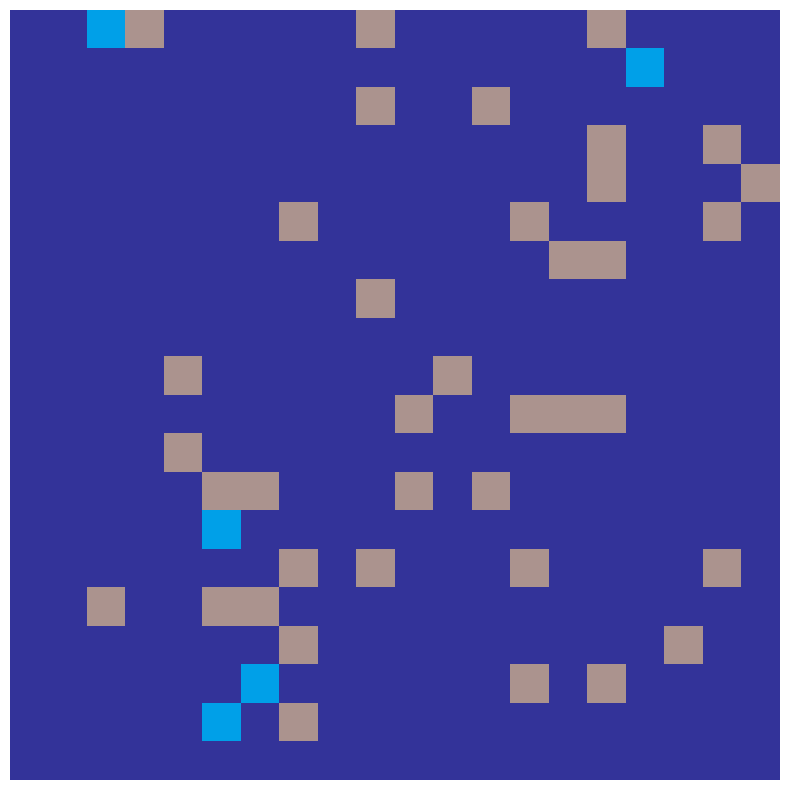

In [276]:
# dibujar el ultimo paso de la simulación
grid = all_grid.iloc[-1]["Grid"]
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
ax.imshow(all_grid.iloc[4070][0], cmap="terrain", vmin=0, vmax=6)
plt.axis("off")

print("Número de pilas llenas:", np.count_nonzero(grid == 5))
print("Número de pilas incompletas:", np.count_nonzero(grid == 4))
print("Número de cajas:", np.count_nonzero(grid == 3))

C:\Users\david\AppData\Local\Temp\ipykernel_47084\762194702.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap="terrain", vmin=0, vmax=6)


C:\Users\david\AppData\Local\Temp\ipykernel_47084\762194702.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


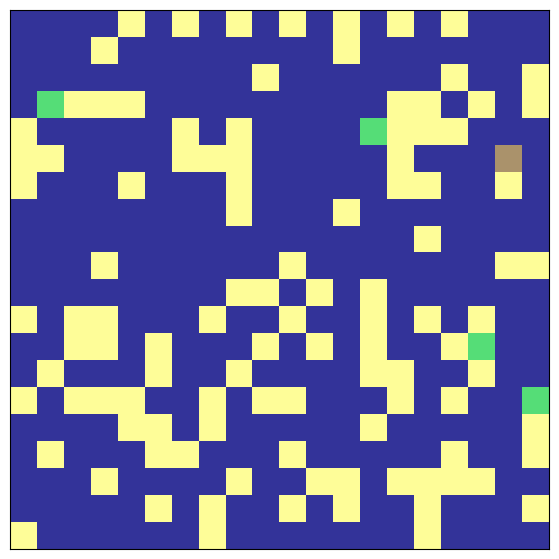

In [266]:
fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap="terrain", vmin=0, vmax=6)


def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    return (patch,)

anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))
# anim = animation.FuncAnimation(fig, animate, frames=500, blit=True)

In [267]:
anim

C:\Users\david\AppData\Local\Temp\ipykernel_47084\762194702.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


KeyboardInterrupt: 